# Practica Deep Learning Alejandro Taboada

## Objetivo de la practica

El objetivo de esta práctica es aplicar los conocimientos adquiridos en la asignatura de Deep Learning para resolver un problema de regresión. Para ello, se utilizará un dataset de Airbnb en Madrid, que contiene información sobre las características de las viviendas y sus precios. El objetivo es predecir el precio de una vivienda en función de sus características.

Para ello, se utilizará una red neuronal de tipo feedforward, que será entrenada con el dataset de Airbnb. La red neuronal tendrá una capa de entrada con el mismo número de neuronas que características tenga el dataset, una capa oculta con un número de neuronas a determinar y una capa de salida con una única neurona que prediga el precio de la vivienda.

Además, se utilizará un dataset de imágenes de las viviendas, que se utilizará para entrenar una red neuronal convolucional. La red neuronal convolucional tendrá una capa de entrada con el mismo número de neuronas que características tenga el dataset, una capa oculta con un número de neuronas a determinar y una capa de salida con una única neurona que prediga el precio de la vivienda.

Finalmente, se compararán los resultados obtenidos por ambas redes neuronales y se analizarán los resultados obtenidos.

## 1.- Carga de librearías y funciones de apoyo

En esta fase, preparamos todas las configuraciones del proyecto

- Cargamos las librerias
- Definimos funciones auxiliares que nos ayudarán en el desarrollo

In [145]:
import pandas as pd
import numpy as np
import tensorflow as tf
import requests as req
import cv2
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Optional,Union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from keras.applications import VGG16, VGG19
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Flatten



In [146]:
def limpieza(df):
    #Borrado punto 1
    rowsToDrop = ['ID','Thumbnail Url','Listing Url','Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location','Host About', 'Host Response Time', 'Host Response Rate','Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url','Host Neighbourhood', 'Host Listings Count','Host Total Listings Count', 'Host Verifications','Calculated host listings count','Name', 'Summary','Space', 'Description', 'Experiences Offered', 'Neighborhood Overview','Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Medium Url', 'Picture Url', 'XL Picture Url','Scrape ID', 'Last Scraped','Calendar last Scraped','Features','Calendar Updated']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado punto 2
    rowsToDrop = ['Square Feet','Has Availability','License','Jurisdiction Names']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado punto 3
    rowsToDrop = ['Weekly Price','Monthly Price']
    df = df.drop(rowsToDrop, axis=1)

    #Filtrado punto 4
    cities_permitidos = ['Madrid', 'madrid','MADRID','Madri','Madrid, Comunidad de Madrid, ES','Madrid, Comunidad de Madrid, ESPANA','Aravaca','Aravaca (Madrid)','Boadilla del Monte','Centro','Centro, Madrid','Chueca','Chueca, Madrid','Comunidad de Madrid','Delicias','Delicias-Madrid','Madrid, Vallecas (Fontarrón)','Motilla del Palancar','Pozuelo','Pozuelo de Alarcón','San Fernando de Henares','Valderrodrigo','Ventas','las matas  madrid','villa verde bajo','馬德里','马德里']
    df = df[df['City'].isin(cities_permitidos)]
    rowsToDrop = ['Street','Neighbourhood','Neighbourhood Group Cleansed','City','Zipcode','State','Market','Smart Location','Country Code','Country','Latitude','Longitude','Geolocation']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado Security Deposit
    df = df.drop(['Security Deposit'], axis=1)

    #Borrado Availability y derivadas
    rowsToDrop = ['Availability 30','Availability 60','Availability 90','Availability 365']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado de Nights
    rowsToDrop = ['Minimum Nights','Maximum Nights']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado de fechas de reviews
    rowsToDrop = ['First Review','Last Review']
    df = df.drop(rowsToDrop, axis=1)

    #Borrado de reviews
    rowsToDrop = ['Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin','Review Scores Communication','Review Scores Value','Reviews per Month']
    df = df.drop(rowsToDrop, axis=1)

    return df

In [147]:
def imputacion(df):
    #Cleaning Fee a 0
    df.loc[df[df['Cleaning Fee'].isna()].index, 'Cleaning Fee'] = 0

    #Los NA de reviews Scores Rating y Reviews Scores Locatiopn se impurtan con la media de cada barrio
    df['Review Scores Rating'] = df['Review Scores Rating'].fillna(df.groupby('Neighbourhood Cleansed')['Review Scores Rating'].transform('mean'))
    df['Review Scores Location'] = df['Review Scores Location'].fillna(df.groupby('Neighbourhood Cleansed')['Review Scores Location'].transform('mean'))
    #El barrio Fuentelareina no tiene reviews, por lo que se imputa con valor 0
    df.loc[df[df['Neighbourhood Cleansed'] == 'Fuentelareina'].index, 'Review Scores Rating'] = 0
    df.loc[df[df['Neighbourhood Cleansed'] == 'Fuentelareina'].index, 'Review Scores Location'] = 0

    #Los NA de amenities los convertimos en cadenas vacías
    df['Amenities'] = df['Amenities'].fillna('')

    return df

In [148]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
    """ Download a list of images from url adresses, converting them to a specific
    canvas size.
  
    Args:
      paths: Paths or url adresses from which to load images.
      canvas: Desired image width and height.
      nb_channels: Channels in images (1 for B/W, 3 for RGB).
      max_imgs: Upper threshold in the number of images to download.
  
    Return:
      a tuple of:
        - image values
        - indices within the paths that were successfull.
  
    """
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels),
                      dtype=np.uint8)
    downloaded_idxs = []

    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:  # Unavailable url / conversion error
            pass
    return images[downloaded_idxs], downloaded_idxs

## 2.- Lectura y preparación del dataset

Heradamos la limpieza realizada en la anterior práctica de Machine Learning, para ellos definiremos 3 funciones:
- borrado de columnas que no aportan información tras el estudio
- convertir columnas categorias en numéricas
- borrado de columnas con NA

### 2.1- Descarga del dataset

Descargamos los listings de airbnb y las imagenes. Para una mejor operativa, solo lo hacemos si todavía no están descargados.

In [149]:

try:
    df = pd.read_csv("airbnb-listings.csv", sep=";")
except:
    respuesta = req.get("https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B")
    with open("airbnb-listings.csv", 'wb') as archivo_local:
        archivo_local.write(respuesta.content)

In [150]:
dataframe = pd.read_csv("airbnb-listings.csv", sep = ';')
dataframe = dataframe.dropna(subset=['Price'])

### 2.2- Descarga de las imágenes

In [151]:
import os
if os.path.exists("images.npy"):
    idxs = np.load("idxs.npy")
    images = np.load("images.npy")
else:
    images, idxs = download_images(dataframe['Thumbnail Url'], max_imgs=5000)
    images = images.astype("float32") / 255.
    images.shape
    np.save('idxs.npy', idxs)
    np.save('images.npy', images)

100%|██████████| 5000/5000 [30:07<00:00,  2.77it/s]  


### 2.3- Guardado de los datos

In [152]:
#guardamos idxs e images en variables
idxs = np.load("idxs.npy")
images = np.load("images.npy")
idxs.shape, images.shape


((3182,), (3182, 224, 224, 3))

In [153]:
filtered_data = dataframe.iloc[idxs]
#filtered_images = images[idxs]

In [154]:
filtered_data.to_csv('filtered_data.csv', sep=';', index=False)
#filtered_images.data('filtered_images.npy', filtered_images)

In [155]:
# Comprobamos a abrirlos de nuevo
saved_data = pd.read_csv("filtered_data.csv", sep=';')
saved_imgs = np.load("images.npy")
saved_data.shape, saved_imgs.shape

((3182, 89), (3182, 224, 224, 3))

### 2.4- Limpieza del dataset

Aplicamos al dataframe filtrado la función de limpieza para quedarnos solo con las características mas relevantes

In [156]:
saved_data = limpieza(saved_data)

### 2.5- Imputación y categorización

Hacemos one hot enconding a las columnas categóricas:
  - Neighbourhood Cleansed
  - Room Type
  - Bed Type
  - Property Type
  - Cancellation Policy 

  Imputamos valores nulos según la función de imputación.
  Y creamos una columna nueva con el número de amenities que tiene el inmueble

In [157]:
saved_data = imputacion(saved_data)
saved_data = pd.get_dummies(saved_data, columns = ['Neighbourhood Cleansed', 'Room Type', 'Bed Type', 'Property Type', 'Cancellation Policy'])
saved_data['amenities_count'] = saved_data['Amenities'].apply(lambda x: len(str(x).split(',')) if isinstance(x, str) else 0)
saved_data.drop(columns=['Amenities'], inplace=True)
saved_data = saved_data.replace({True: 1, False: 0})

C:\Users\aleja\AppData\Local\Temp\ipykernel_13928\1985712694.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  saved_data = saved_data.replace({True: 1, False: 0})


### 2.6- Borrado de NA

In [158]:
saved_data = saved_data.dropna()

### 2.7- Separación en train, validation y test

In [159]:
#separamos el dataset en train y test
X = saved_data.drop(['Price'], axis=1)
y = saved_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#ahora separamos el train en train y validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# El dataset ya está dividido en train, validation y test. Dentro de cada uno
# de estos subsets ver el número de ejemplos y las dimensiones:
print("El conjunto de entrenamiento tiene dimensiones: ", X_train.shape)
print("El conjunto de validación tiene dimensiones: ",X_val.shape)
print("El conjunto de test tiene dimensiones: ",X_test.shape)

#Hacemos lo mismo para las etiquetas.
print("El conjunto de entrenamiento (etiquetas) tiene dimensiones: ", y_train.shape)
print("El conjunto de validación (etiquetas) tiene dimensiones: ",y_val.shape)
print("El conjunto de test (etiquetas) tiene dimensiones: ",y_test.shape)




El conjunto de entrenamiento tiene dimensiones:  (1946, 160)
El conjunto de validación tiene dimensiones:  (487, 160)
El conjunto de test tiene dimensiones:  (609, 160)
El conjunto de entrenamiento (etiquetas) tiene dimensiones:  (1946,)
El conjunto de validación (etiquetas) tiene dimensiones:  (487,)
El conjunto de test (etiquetas) tiene dimensiones:  (609,)


### 2.8- Escalado y estandarización de las columnas de Xtrain

In [160]:
X_train.head()

,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Number of Reviews,Review Scores Rating,Review Scores Location,...,Property Type_Hostel,Property Type_House,Property Type_Loft,Property Type_Other,Property Type_Villa,Cancellation Policy_flexible,Cancellation Policy_moderate,Cancellation Policy_strict,Cancellation Policy_super_strict_60,amenities_count
1241,2,1.0,1.0,2.0,0.0,1,0,27,95.000000,10.000000,...,0,0,0,0,0,0,0,1,0,20
1641,2,1.0,1.0,2.0,5.0,2,15,26,87.000000,10.000000,...,0,0,0,0,0,0,0,1,0,10
1386,1,2.0,1.0,1.0,0.0,1,0,0,89.815789,9.552632,...,0,1,0,0,0,1,0,0,0,8
443,2,1.0,1.0,1.0,20.0,15,15,5,100.000000,10.000000,...,0,0,0,0,0,1,0,0,0,16
664,2,1.0,2.0,2.0,0.0,1,0,1,100.000000,8.000000,...,0,0,0,0,0,1,0,0,0,13


In [161]:
columns = ['Accommodates','Bathrooms','Bedrooms','Beds','Cleaning Fee','Guests Included','Extra People','Number of Reviews','Review Scores Rating','Review Scores Location','amenities_count']
minmaxscaler = MinMaxScaler()
X_train[columns] = minmaxscaler.fit_transform(X_train[columns])
X_val[columns] = minmaxscaler.transform(X_val[columns])
X_test[columns] = minmaxscaler.transform(X_test[columns])

#usamos el mismo scaler con las etiquetas pero aplicando un reshape
y_train = minmaxscaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = minmaxscaler.transform(y_val.values.reshape(-1, 1))
y_test = minmaxscaler.transform(y_test.values.reshape(-1, 1))

In [162]:
X_train

,Accommodates,Bathrooms,Bedrooms,Beds,Cleaning Fee,Guests Included,Extra People,Number of Reviews,Review Scores Rating,Review Scores Location,...,Property Type_Hostel,Property Type_House,Property Type_Loft,Property Type_Other,Property Type_Villa,Cancellation Policy_flexible,Cancellation Policy_moderate,Cancellation Policy_strict,Cancellation Policy_super_strict_60,amenities_count
1241,0.066667,0.125,0.1,0.066667,0.00,0.000000,0.000000,0.078488,0.950000,1.000000,...,0,0,0,0,0,0,0,1,0,0.655172
1641,0.066667,0.125,0.1,0.066667,0.02,0.071429,0.055351,0.075581,0.870000,1.000000,...,0,0,0,0,0,0,0,1,0,0.310345
1386,0.000000,0.250,0.1,0.000000,0.00,0.000000,0.000000,0.000000,0.898158,0.955263,...,0,1,0,0,0,1,0,0,0,0.241379
443,0.066667,0.125,0.1,0.000000,0.08,1.000000,0.055351,0.014535,1.000000,1.000000,...,0,0,0,0,0,1,0,0,0,0.517241
664,0.066667,0.125,0.2,0.066667,0.00,0.000000,0.000000,0.002907,1.000000,0.800000,...,0,0,0,0,0,1,0,0,0,0.413793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,0.000000,0.125,0.1,0.000000,0.08,0.000000,0.000000,0.000000,0.930857,0.997143,...,0,1,0,0,0,1,0,0,0,0.275862
1675,0.066667,0.125,0.1,0.000000,0.02,0.000000,0.000000,0.250000,0.960000,1.000000,...,0,0,0,0,0,1,0,0,0,0.310345
1599,0.200000,0.125,0.1,0.000000,0.12,0.000000,0.036900,0.000000,0.913158,0.992105,...,0,0,0,0,0,1,0,0,0,0.413793
809,0.200000,0.125,0.2,0.000000,0.16,0.071429,0.055351,0.020349,0.870000,0.800000,...,0,0,0,0,0,0,0,1,0,0.448276


In [163]:
y_train

array([[0.10752688],
       [0.06451613],
       [0.04301075],
       ...,
       [0.13763441],
       [0.13978495],
       [0.06451613]])

## 3.- Red para datos tabulares

Para entrenar un modelo con los datos tabulares, comenzaremos haciendo una red muy simple, con la capa de entrada y la de salida.

La capa de entrada tendrá el mismo número de neuronas que columnas tiene el dataset, y una salida única para el precio, con una activación linear.

In [164]:
def show_plot(modelo, tipo, H, n_epochs=None,batch_size=None,do=None,learning_rate=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
    plt.suptitle( modelo + " / " + tipo)
    plt.title("n_epochs:"+str(n_epochs)+ " / batch_size:"+str(batch_size)+ " / learning_rate:"+ str(learning_rate) + " / dropout:"+str(do) )
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Hacemos la red mas simple, una capa de entrada con tantas neuronas como características, y una de salida con el precio. Usamos salida linear

Epoch 1/200
16/16 [==============================] - 1s 16ms/step - loss: 0.5172 - mean_squared_error: 0.5172 - val_loss: 0.0575 - val_mean_squared_error: 0.0575
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 0.3265 - mean_squared_error: 0.3265 - val_loss: 0.0500 - val_mean_squared_error: 0.0500
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2658 - mean_squared_error: 0.2658 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.2318 - mean_squared_error: 0.2318 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 0.1975 - mean_squared_error: 0.1975 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 7/200
16/16 [==============

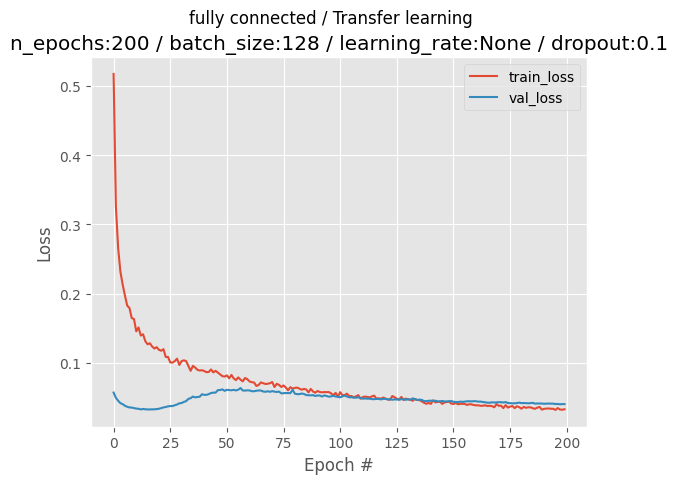

In [165]:
#Defición de variables
do = 0.1
n_epochs = 200
batch_size = 128
learning_rate = 0.001
n_col = X_train.shape[1]
#Definición del modelo
model = Sequential()
model.add(Dense(n_col, input_shape=(n_col,), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(do))
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(do))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error", optimizer=SGD(learning_rate=0.001), metrics=["mean_squared_error"])
#Entremaniento del modelo
H = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val))
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
#Pintar gráfica
show_plot("fully connected","Transfer learning",H,n_epochs,batch_size,do)



Repetimos el experimento, añadiendo emtre la capa de entrada de salida un batch y un droouot para prevenis el overfitting

## 4.- Red para imágenes

### 4.1- Carga de imágenes

Comprobamos que las imágenes se han cargado correctamente

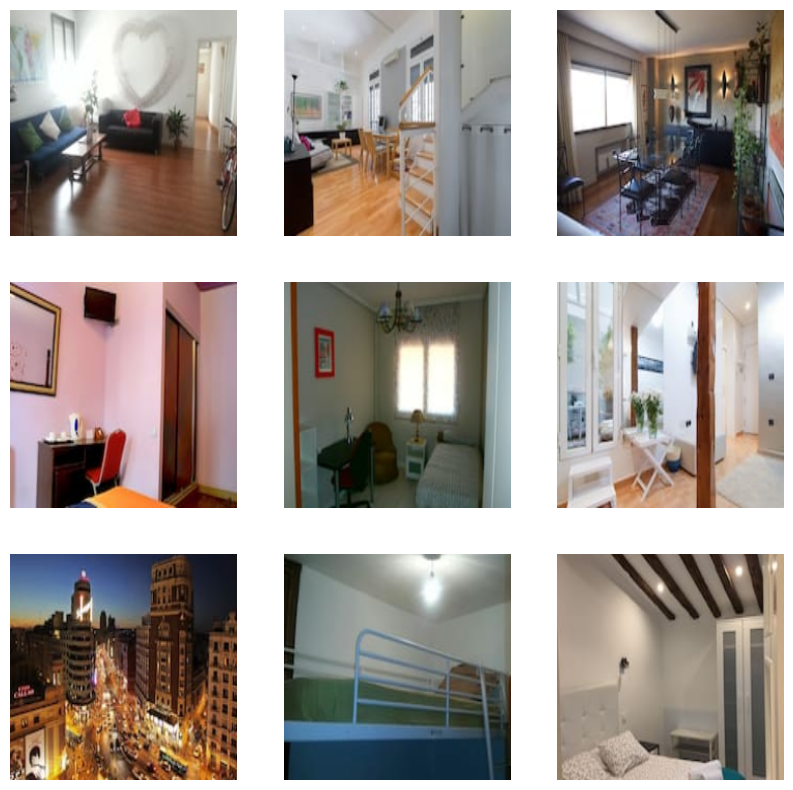

In [166]:
images = np.load("images.npy")
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


Seleccionamos las imágenes para cada uno de los grupos, y comprobamos que se correspondan con los datos

In [167]:
X_train_imgs = images[X_train.index]
X_test_imgs = images[X_test.index]
X_val_imgs = images[X_val.index]

print('Shapes de los datos',X_train.shape, X_test.shape, X_val.shape)
print('Shapes de las imagenes',X_train_imgs.shape, X_test_imgs.shape, X_val_imgs.shape)

Shapes de los datos (1946, 160) (609, 160) (487, 160)
Shapes de las imagenes (1946, 224, 224, 3) (609, 224, 224, 3) (487, 224, 224, 3)


Estadarizamos el precio usando standarScaler

In [168]:
scaler_img = StandardScaler()
Y_train_scaled = scaler_img.fit_transform(y_train)
Y_val_scaled = scaler_img.transform(y_val)
Y_test_scaled = scaler_img.transform(y_test)

### 4.2- Entrenamiento de modelos

Descargamos un modelo preentrenado de keras para hacer transfer learning. Comenzamos con VGG16

#### 4.2.1- VGG16

In [169]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_18 (Flatten)        (None, 25088)             0         
                                                                 
 dense_64 (Dense)            (None, 512)               12845568  
                                                                 
 batch_normalization_26 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_65 (Dense)            (None, 1)                 513       
                                                     

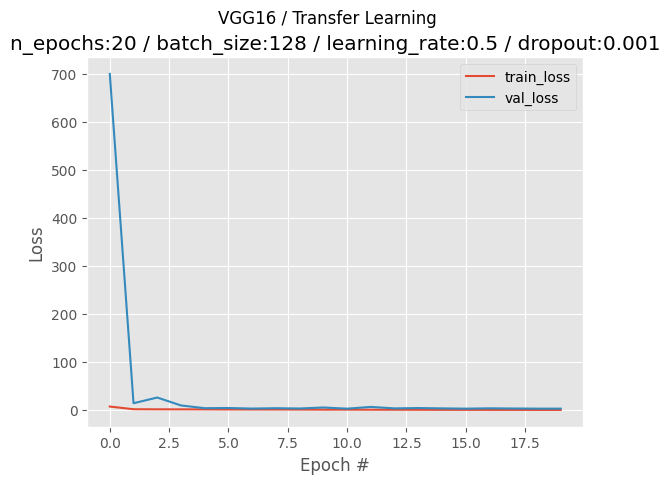

In [170]:
#Variables
n_epochs = 20
batch_size = 128
learning_rate = 0.001
do = 0.5

#Modelo con transfer learning
model = Sequential()
model.add(base_model)
model.add(Flatten())
#capas intermedias
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(do))
#capa de salida
model.add(Dense(1, activation='linear'))

#Congelamos todas las capas de la red menos las 3 ultimas, la de salida y las dos anteriores
for layer in base_model.layers[:-3]:
    layer.trainable = False
    
#Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

#Entrenamos el modelo
H = model.fit(X_train_imgs, Y_train_scaled, validation_data=(X_val_imgs, Y_val_scaled), epochs=n_epochs, batch_size=batch_size)

#Evaluamos el modelo
loss = model.evaluate(X_test_imgs, Y_test_scaled)
print("Test Loss:", loss)

#Muestro gráfica de loss
show_plot("VGG16","Transfer Learning",H,n_epochs,batch_size,learning_rate,do)

Ahhora sobre el modelo anterior, vamos a entrenar el modelo haciendo fine tunning con una sola capa.

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_19 (Flatten)        (None, 25088)             0         
                                                                 
 dense_66 (Dense)            (None, 512)               12845568  
                                                                 
 batch_normalization_27 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_67 (Dense)            (None, 1)                 513       
                                                     

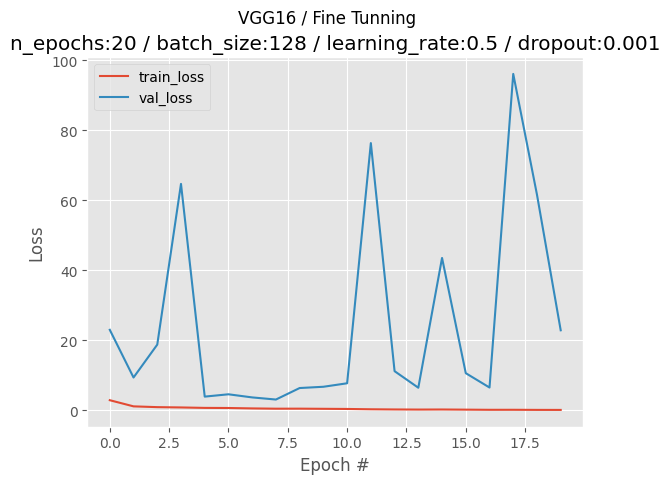

In [171]:
#Variables
n_epochs = 20
batch_size = 128
learning_rate = 0.001
do = 0.5

#Modelo con transfer learning
model = Sequential()
model.add(base_model)
model.add(Flatten())
#capas intermedias
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(do))
#capa de salida
model.add(Dense(1, activation='linear'))

#Congelamos todas las capas de la red menos las 3 ultimas, la de salida y las dos anteriores
for layer in base_model.layers[:-4]:
    layer.trainable = False
    
#Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

#Entrenamos el modelo
H = model.fit(X_train_imgs, Y_train_scaled, validation_data=(X_val_imgs, Y_val_scaled), epochs=n_epochs, batch_size=batch_size)

#Evaluamos el modelo
loss = model.evaluate(X_test_imgs, Y_test_scaled)
print("Test Loss:", loss)

#Muestro gráfica de loss
show_plot("VGG16","Fine Tunning",H,n_epochs,batch_size,learning_rate,do)

#### 4.2.2- VGG19

In [172]:
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_20 (Flatten)        (None, 25088)             0         
                                                                 
 dense_68 (Dense)            (None, 512)               12845568  
                                                                 
 batch_normalization_28 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 1)                 513       
                                                     

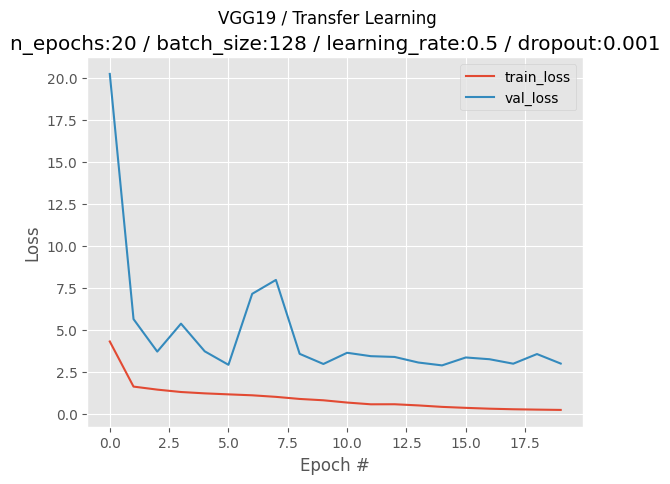

In [173]:
#Variables
n_epochs = 20
batch_size = 128
learning_rate = 0.001
do = 0.5

#Modelo con transfer learning
model = Sequential()
model.add(base_model)
model.add(Flatten())
#capas intermedias
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(do))
#capa de salida
model.add(Dense(1, activation='linear'))

#Congelamos todas las capas de la red menos las 3 ultimas, la de salida y las dos anteriores
for layer in base_model.layers[:-3]:
    layer.trainable = False
    
#Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

#Entrenamos el modelo
H = model.fit(X_train_imgs, Y_train_scaled, validation_data=(X_val_imgs, Y_val_scaled), epochs=n_epochs, batch_size=batch_size)

#Evaluamos el modelo
loss = model.evaluate(X_test_imgs, Y_test_scaled)
print("Test Loss:", loss)

#Muestro gráfica de loss
show_plot("VGG19","Transfer Learning",H,n_epochs,batch_size,learning_rate,do)

In [174]:
#Variables
n_epochs = 20
batch_size = 128
learning_rate = 0.001
do = 0.5

#Modelo con transfer learning
model = Sequential()
model.add(base_model)
model.add(Flatten())
#capas intermedias
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(do))
#capa de salida
model.add(Dense(1, activation='linear'))

#Congelamos todas las capas de la red menos las 3 ultimas, la de salida y las dos anteriores
for layer in base_model.layers[:-4]:
    layer.trainable = False
    
#Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

#Entrenamos el modelo
H = model.fit(X_train_imgs, Y_train_scaled, validation_data=(X_val_imgs, Y_val_scaled), epochs=n_epochs, batch_size=batch_size)

#Evaluamos el modelo
loss = model.evaluate(X_test_imgs, Y_test_scaled)
print("Test Loss:", loss)

#Muestro gráfica de loss
show_plot("VGG19","Fine Tunning",H,n_epochs,batch_size,learning_rate,do)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_70 (Dense)            (None, 512)               12845568  
                                                                 
 batch_normalization_29 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_71 (Dense)            (None, 1)                 513       
                                                     

KeyboardInterrupt: 